In [2]:
library(sits)
library(sitsdata)
library(dplyr)
library(ggplot2)
library(plotly)
library(stars)

In [3]:
# Configure plot size 
options(repr.plot.width = 15, repr.plot.height = 6)

In [5]:
read_file <- function(file, ext) {
  data.tb <- NULL
  if (ext == "csv") {
    data.tb <- read.csv(file)
  }
  if (ext == "rds") {
    data.tb <- readRDS(file)
  }
  if (ext == "rda") {
    data.tb <- get(load(file))
  }
  return(data.tb)
}

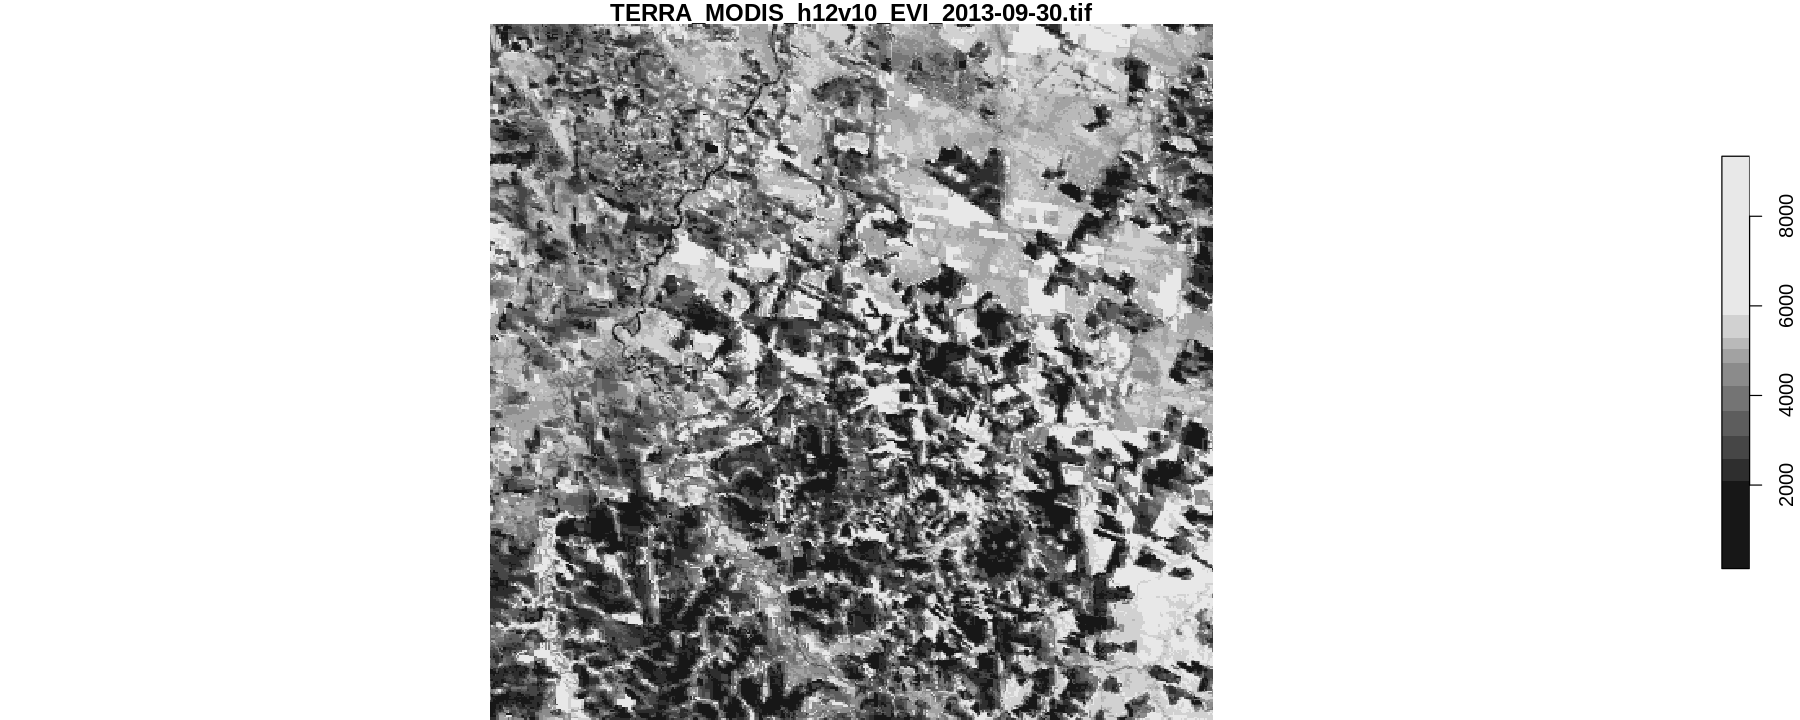

In [6]:
data_dir <- system.file("extdata/sinop", package = "sitsdata")
sinop_cube <- sits_cube(
    source = "LOCAL",
    satellite = "TERRA",
    sensor  = "MODIS",
    name = "Sinop",
    data_dir = data_dir
)
plot(sinop_cube, band = "EVI", time = 2)

In [7]:
# input_data.tb <- read_file("./data/samples_workshop_bdc.rds", "rds")
input_data.tb <- read_file("./data/samples_cerrado_cbers.rda", "rda")
# input_data.tb <- read_file("./data/samples_rondonia_sentinel2.rda", "rda")

In [8]:
filtered <- dplyr::filter(input_data.tb,  label == "Cropland")

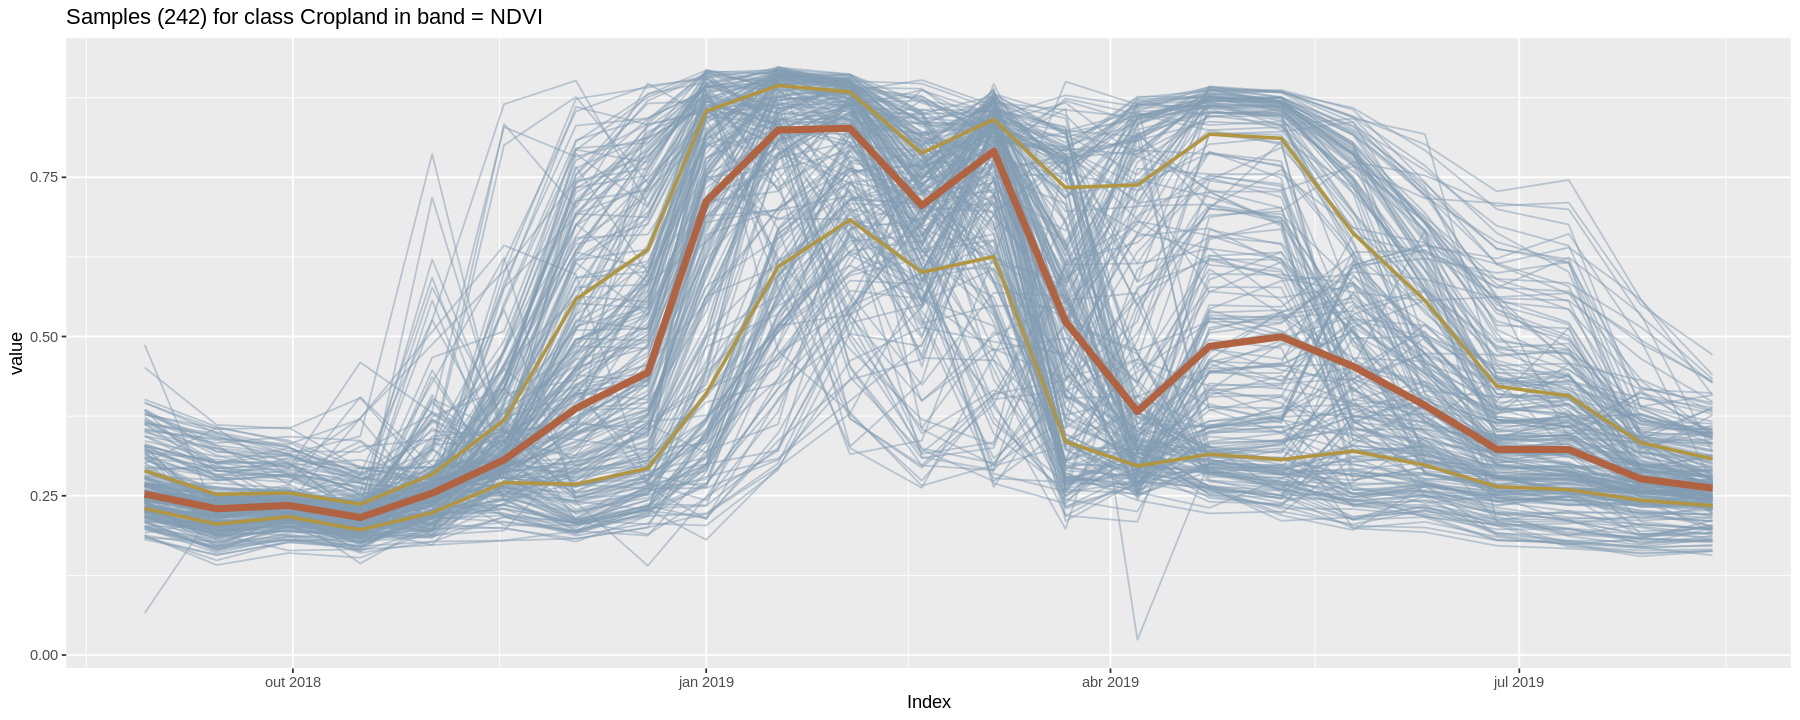

In [9]:
plot(sits_select(filtered, bands = "NDVI"))

In [21]:
wtss_inpe <- "https://brazildatacube.dpi.inpe.br/wtss/"

In [23]:
Rwtss::list_coverages(wtss_inpe)

[1] "MOD13Q1-6"               "MYD13Q1-6"              
 [3] "S2_10_16D_STK-1"         "S2-SEN2COR_10_16D_STK-1"
 [5] "S2_10-1"                 "CB4MUX_20-1"            
 [7] "CB4MUX_20_1M_STK-1"      "LC8_30-1"               
 [9] "LC8_30_16D_STK-1"        "CB4_20_1M_STK-1"        
[11] "LC8_30_6M_MEDSTK-1"      "CB4_64_16D_STK-1"       
[13] "CB4_64-1"                "LANDSAT-MOZ_30_1M_STK-1"

In [25]:
desc <- Rwtss::describe_coverage(wtss_inpe, name = "MOD13Q1-6")
desc$timeline

---------------------------------------------------------------------
WTSS server URL = https://brazildatacube.dpi.inpe.br/wtss
Cube (coverage) = MOD13Q1-6

|satellite|sensor|bands                                                                                                                                                                                                                                                                                                                             |
|:--------|:-----|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|TERRA    |MODIS |view_zenith_angle        , sun_zenith_angle         , pixel_reliability        , relative_azimuth_angle   , blue_reflectance         , red_re

[[1]]
  [1] "2000-02-18" "2000-03-05" "2000-03-21" "2000-04-06" "2000-04-22"
  [6] "2000-05-08" "2000-05-24" "2000-06-09" "2000-06-25" "2000-07-11"
 [11] "2000-07-27" "2000-08-12" "2000-08-28" "2000-09-13" "2000-09-29"
 [16] "2000-10-15" "2000-10-31" "2000-11-16" "2000-12-02" "2000-12-18"
 [21] "2001-01-01" "2001-01-17" "2001-02-02" "2001-02-18" "2001-03-06"
 [26] "2001-03-22" "2001-04-07" "2001-04-23" "2001-05-09" "2001-05-25"
 [31] "2001-06-10" "2001-06-26" "2001-07-12" "2001-07-28" "2001-08-13"
 [36] "2001-08-29" "2001-09-14" "2001-09-30" "2001-10-16" "2001-11-01"
 [41] "2001-11-17" "2001-12-03" "2001-12-19" "2002-01-01" "2002-01-17"
 [46] "2002-02-02" "2002-02-18" "2002-03-06" "2002-03-22" "2002-04-07"
 [51] "2002-04-23" "2002-05-09" "2002-05-25" "2002-06-10" "2002-06-26"
 [56] "2002-07-12" "2002-07-28" "2002-08-13" "2002-08-29" "2002-09-14"
 [61] "2002-09-30" "2002-10-16" "2002-11-01" "2002-11-17" "2002-12-03"
 [66] "2002-12-19" "2003-01-01" "2003-01-17" "2003-02-02" "2003-02-18"
 [71] "2003-03-06" "2003-03-22" "2003-04-07" "2003-04-23" "2003-05-09"
 [76] "2003-05-25" "2003-06-10" "2003-06-26" "2003-07-12" "2003-07-28"
 [81] "2003-08-13" "2003-08-29" "2003-09-14" "2003-09-30" "2003-10-16"
 [86] "2003-11-01" "2003-11-17" "2003-12-03" "2003-12-19" "2004-01-01"
 [91] "2004-01-17" "2004-02-02" "2004-02-18" "2004-03-05" "2004-03-21"
 [96] "2004-04-06" "2004-04-22" "2004-05-08" "2004-05-24" "2004-06-09"
[101] "2004-06-25" "2004-07-11" "2004-07-27" "2004-08-12" "2004-08-28"
[106] "2004-09-13" "2004-09-29" "2004-10-15" "2004-10-31" "2004-11-16"
[111] "2004-12-02" "2004-12-18" "2005-01-01" "2005-01-17" "2005-02-02"
[116] "2005-02-18" "2005-03-06" "2005-03-22" "2005-04-07" "2005-04-23"
[121] "2005-05-09" "2005-05-25" "2005-06-10" "2005-06-26" "2005-07-12"
[126] "2005-07-28" "2005-08-13" "2005-08-29" "2005-09-14" "2005-09-30"
[131] "2005-10-16" "2005-11-01" "2005-11-17" "2005-12-03" "2005-12-19"
[136] "2006-01-01" "2006-01-17" "2006-02-02" "2006-02-18" "2006-03-06"
[141] "2006-03-22" "2006-04-07" "2006-04-23" "2006-05-09" "2006-05-25"
[146] "2006-06-10" "2006-06-26" "2006-07-12" "2006-07-28" "2006-08-13"
[151] "2006-08-29" "2006-09-14" "2006-09-30" "2006-10-16" "2006-11-01"
[156] "2006-11-17" "2006-12-03" "2006-12-19" "2007-01-01" "2007-01-17"
[161] "2007-02-02" "2007-02-18" "2007-03-06" "2007-03-22" "2007-04-07"
[166] "2007-04-23" "2007-05-09" "2007-05-25" "2007-06-10" "2007-06-26"
[171] "2007-07-12" "2007-07-28" "2007-08-13" "2007-08-29" "2007-09-14"
[176] "2007-09-30" "2007-10-16" "2007-11-01" "2007-11-17" "2007-12-03"
[181] "2007-12-19" "2008-01-01" "2008-01-17" "2008-02-02" "2008-02-18"
[186] "2008-03-05" "2008-03-21" "2008-04-06" "2008-04-22" "2008-05-08"
[191] "2008-05-24" "2008-06-09" "2008-06-25" "2008-07-11" "2008-07-27"
[196] "2008-08-12" "2008-08-28" "2008-09-13" "2008-09-29" "2008-10-15"
[201] "2008-10-31" "2008-11-16" "2008-12-02" "2008-12-18" "2009-01-01"
[206] "2009-01-17" "2009-02-02" "2009-02-18" "2009-03-06" "2009-03-22"
[211] "2009-04-07" "2009-04-23" "2009-05-09" "2009-05-25" "2009-06-10"
[216] "2009-06-26" "2009-07-12" "2009-07-28" "2009-08-13" "2009-08-29"
[221] "2009-09-14" "2009-09-30" "2009-10-16" "2009-11-01" "2009-11-17"
[226] "2009-12-03" "2009-12-19" "2010-01-01" "2010-01-17" "2010-02-02"
[231] "2010-02-18" "2010-03-06" "2010-03-22" "2010-04-07" "2010-04-23"
[236] "2010-05-09" "2010-05-25" "2010-06-10" "2010-06-26" "2010-07-12"
[241] "2010-07-28" "2010-08-13" "2010-08-29" "2010-09-14" "2010-09-30"
[246] "2010-10-16" "2010-11-01" "2010-11-17" "2010-12-03" "2010-12-19"
[251] "2011-01-01" "2011-01-17" "2011-02-02" "2011-02-18" "2011-03-06"
[256] "2011-03-22" "2011-04-07" "2011-04-23" "2011-05-09" "2011-05-25"
[261] "2011-06-10" "2011-06-26" "2011-07-12" "2011-07-28" "2011-08-13"
[266] "2011-08-29" "2011-09-14" "2011-09-30" "2011-10-16" "2011-11-01"
[271] "2011-11-17" "2011-12-03" "2011-12-19" "2012-01-01" "2012-01-17"
[276] "2012-02-02" "2012-02-18" "2012-03-05" "2012-03-21" "2012-04-06"
[281] "2012-04-22"

In [27]:
install.packages("ggmap")

also installing the dependencies ‘RgoogleMaps’, ‘rjson’, ‘jpeg’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [28]:
long <- -53.11
lat <- -14.91

library(ggmap)
points <- data.frame(lon = long, lat = lat)

map <- get_map(location = "BRAZIL", zoom = 5)

ggmap(map) + 
  geom_point(data=points,color="red", size=3
             , alpha=0.5) + labs(x = "longitude", y = "latitude", title = "A Location in MT, Brazil")

Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.

Please cite ggmap if you use it! See citation("ggmap") for details.


Attaching package: ‘ggmap’


The following object is masked from ‘package:plotly’:

    wind




ERROR: Error: Google now requires an API key.
       See ?register_google for details.
